# English 2 French Machine Translation with Transformer Model and Tensorflow

In [1]:
%autosave 300

Autosaving every 300 seconds


## Table of Contents
[1. Data Preparation](#1.-Data-Preparation)  
[1.1 Load Data and Normalize Characters](#1.1-Load-Data-and-Normalize-Characters)  
[1.2 Extract Sentence Length Information](#1.2-Extract-Sentence-Length-Information)  
[1.3 Remove Duplicate English lines](#1.3-Remove-Duplicate-English-lines)  
[1.4 Add "start' and "end" Tokens](#1.4-Add-"start"-and-"end"-Tokens)  
[1.5 Split into train, validation, and test pairs](#1.5-Split-into-train,-validation,-and-test-pairs)

[2. Vectorizing the English and French text pairs](#2.-Vectorizing-the-English-and-French-text-pairs)  
[2.1 Preparing datasets for the translation task](#2.1-Preparing-datasets-for-the-translation-task)

[3. Sequence to Sequence Transformer Model for Machine Translation](#3.-Sequence-to-Sequence-Transformer-Model-for-Machine-Translation)  
[3.1 Transformer Encoder](#3.1-Transformer-Encoder)  
[3.2 Positional Embedding layer](#3.2-Positional-Embedding-layer)
[3.3 Transformer Decoder](#3.3-Transformer-Decoder)  
[3.4 End-to-end Transformer Model](#3.4-End-to-end-Transformer-Model)  
[3.5 Translating new sentences with the Transformer model](#3.5-Translating-new-sentences-with-the-Transformer-model)  


In [7]:
import re
import string
import random
from unicodedata import normalize

import numpy as np

## 1. Data Preparation

#### 1.1 Load Data and Normalize Characters

Load the text file and normalize the characters by converting them to Unicode Normalization Form Compatibility Composition (NFKC) format:

In [8]:
with open('fra-eng/fra.txt') as file:
    lines = ''.join(c for c in normalize('NFKC', file.read()))
    lines = lines.split('\n')[:-1]
    
len(lines)

192341

In [9]:
# Three random samples of the data
for line in random.sample(lines, 3):
    print(line, '\n')

Don't cry over spilt milk.	Ce qui est fait est fait.	CC-BY 2.0 (France) Attribution: tatoeba.org #4850071 (CK) & #9549 (sacredceltic) 

He sells cars.	Il vend des voitures.	CC-BY 2.0 (France) Attribution: tatoeba.org #434996 (lukaszpp) & #477542 (mamat) 

I can understand your point of view.	Je peux comprendre votre point de vue.	CC-BY 2.0 (France) Attribution: tatoeba.org #1096486 (CK) & #1099629 (sacredceltic) 



In [10]:
# separate out english and french sentences
english, french = [], []

for line in lines:
    eng, fre, _ = line.split('\t')
    english.append(eng)
    french.append(fre)

#### 1.2 Extract Sentence Length Information
Determine maximum, minimum and average lengths of English and French sentences. This information will help determine the maximum sequence length that will be used when preparing the data for the model.

In [11]:
def sequence_info(sequence):
    seq_len = []
    for seq in sequence:
        seq = seq.split()
        seq_len.append(len(seq))

    return np.max(seq_len), np.min(seq_len), int(np.average(seq_len))

In [12]:
print(f"""- The maximum number of tokens in any English sequence is {sequence_info(english)[0]}
- The minimum number of tokens in any English sequence is {sequence_info(english)[1]}
- The average number of tokens in all English sequences is {sequence_info(english)[2]}""")

- The maximum number of tokens in any English sequence is 47
- The minimum number of tokens in any English sequence is 1
- The average number of tokens in all English sequences is 6


In [13]:
print(f"""- The maximum number of tokens in any French sequence is {sequence_info(french)[0]}
- The minimum number of tokens in any French sequence is {sequence_info(french)[1]}
- The average number of tokens in all French sequences is {sequence_info(french)[2]}""")

- The maximum number of tokens in any French sequence is 55
- The minimum number of tokens in any French sequence is 1
- The average number of tokens in all French sequences is 6


#### 1.3 Remove Duplicate English lines
Duplicates present in the data set will be removed.
E.g "Run!" and "Run." will be treated as duplicates since all punctuations would be removed anyway during text standardization, and thus will be seen as the same by the model.

In [14]:
for line in lines[8:16]:
    print(line, '\n')

Run!	File !	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #2077454 (sacredceltic) 

Run!	Filez !	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #2077455 (sacredceltic) 

Run!	Cours !	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #4580779 (franlexcois) 

Run!	Fuyez !	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #7957917 (Micsmithel) 

Run!	Fuyons !	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #7957918 (Micsmithel) 

Run.	Cours !	CC-BY 2.0 (France) Attribution: tatoeba.org #4008918 (JSakuragi) & #906331 (sacredceltic) 

Run.	Courez !	CC-BY 2.0 (France) Attribution: tatoeba.org #4008918 (JSakuragi) & #906332 (sacredceltic) 

Run.	Prenez vos jambes à vos cous !	CC-BY 2.0 (France) Attribution: tatoeba.org #4008918 (JSakuragi) & #2077449 (sacredceltic) 



###### check if every english sentence ends with a punctuation

In [15]:
pattern = re.compile(f"[{re.escape(string.punctuation)}]$")
test = set()

for seq in english:
    match = re.search(pattern, seq)
    if match is None:
        test.add(0)

# if the set is empty then it means every English sequence with a punctuation.
test        

set()

In [16]:
# Removing the duplicates
idx_non_duplicates = {0}  # add the first index to the set

for n, seq in enumerate(english):
    if n+1 < len(english):
        # if the sequence in the next line is not a duplicate of the current line add the index of the next line to the `idx_non_duplicates` set
        if english[n][:-1] != english[n+1][:-1]:
            idx_non_duplicates.add(n+1)
            
len(idx_non_duplicates)

134757

#### 1.4 Add "start" and "end" Tokens
Add "start' and "end" Tokens to the beginning and end of each non-duplicate French sequence.

In [17]:
# convert to list
idx_non_duplicates = list(idx_non_duplicates)
len(idx_non_duplicates)

134757

In [18]:
for idx in idx_non_duplicates:
    french[idx] = '[start] ' + french[idx] + ' [end]'
    
print(random.sample(french, 3))

['[start] Savez-vous comment résoudre cette énigme ? [end]', 'Continuez à courir.', '[start] Je pourrais essayer. [end]']


##### keep only non-duplicate English lines and its corresponding French translation.

In [19]:
text_pairs = []
for idx in idx_non_duplicates:
    text_pairs.append((english[idx], french[idx]))

print(random.sample(text_pairs, 3))

[('Tom works for the FBI.', '[start] Tom travaille pour le FBI. [end]'), ('Corporations are competing to fill the vacuum.', '[start] Les entreprises se concurrencent pour remplir le vide. [end]'), ("That's Tom's house.", "[start] C'est la maison de Tom. [end]")]


#### 1.5 Split into train, validation, and test pairs

In [20]:
random.shuffle(text_pairs)

num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - (2 * num_val_samples)

train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples:num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples:]

## 2. Vectorizing the English and French text pairs

In [21]:
import tensorflow as tf
from tensorflow.keras import layers

Add French punctuation characters, guillemets (« ») to the `string.punctuation`. The characters in `string.punctuation` will be stripped from the sentences.  
Remove the characters "[" and "]" from `string.punctuation` so that the start and end tokens, "[start]" and "[end]", will be preserved as they are.

In [22]:
strip_chars = string.punctuation + '«' + '»'
strip_chars = strip_chars.replace('[', '')
strip_chars = strip_chars.replace(']', '')

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, 
                                    f'[{re.escape(strip_chars)}]', '')

# restrict vocabulary size to 15,000 words, sentence length to 20 words each.
vocabulary_size = 15_000
sequence_length = 20

# english layer
source_vectorization = layers.TextVectorization(
    max_tokens=vocabulary_size,
    output_mode='int',
    output_sequence_length=sequence_length
)

# french layer
target_vectorization = layers.TextVectorization(
    max_tokens=vocabulary_size,
    output_mode='int',
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization
)

english_train_texts = [pair[0] for pair in train_pairs]
french_train_texts = [pair[1] for pair in train_pairs]

# learn the vocabulary of each language
source_vectorization.adapt(english_train_texts)
target_vectorization.adapt(french_train_texts)

#### 2.1 Preparing datasets for the translation task
Next, convert the data into a `tf.data` pipeline.  
The data pipeline will return a tuple (inputs, target) where inputs is a dict with two keys, transformer “encoder_inputs” (the English sentence) and transformer “decoder_inputs” (the Spanish sentence), and target is the French sentence offset by one step ahead.

In [23]:
batch_size = 64

def format_dataset(eng, fre):
    eng = source_vectorization(eng)
    fre = target_vectorization(fre)
    return ({
        'english': eng,
        'french': fre[:, :-1],  # The end token is excluded to keep inputs and targets at the same length
    }, fre[:, 1:])  # The target French sentence is one step ahead. Both are still the same length.

def make_dataset(pairs):
    eng_texts, fre_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    fre_texts = list(fre_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, fre_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset.shuffle(2048).prefetch(16).cache()  # use in-memory caching to speed up preprocessing

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [24]:
for inputs, targets in train_ds.take(1):
    print(f"inputs['english'].shape: {inputs['english'].shape}")
    print(f"inputs['french'].shape: {inputs['french'].shape}")
    print(f"targets.shape: {targets.shape}")

inputs['english'].shape: (64, 20)
inputs['french'].shape: (64, 20)
targets.shape: (64, 20)


## 3. Sequence to Sequence Transformer Model for Machine Translation

In [25]:
from tensorflow import keras

#### 3.1 Transformer Encoder

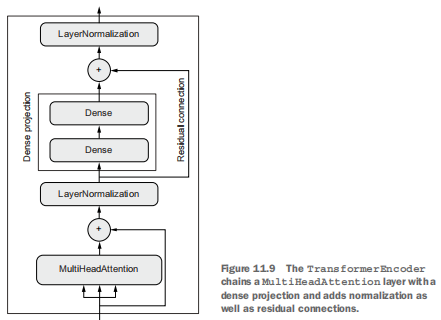  

(Deep Learning in Python, p.343)

In [26]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation='relu'),
            layers.Dense(embed_dim)]
        )
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
                
    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]   # The attention layer expects the mask to be 3D or 4D, so we expand its rank from the 2D mask generated by the Embedding layer.
        attention_outputs = self.attention(
            query=inputs,
            value=inputs,
            attention_mask=mask)
        proj_inputs = self.layernorm_1(inputs + attention_outputs)
        proj_outputs = self.dense_proj(proj_inputs)
        return self.layernorm_2(proj_inputs + proj_outputs)
        
    def get_config(self):
        config = super().get_config()
        config.update({
            'embed_dim': self.embed_dim,
            'dense_dim': self.dense_dim,
            'num_heads': self.num_heads,
        })
        return config

#### 3.2 Positional Embedding layer

In [27]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        # embedding layer for the token indices
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        # embedding layer for the token positions
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim
        
    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        # add the both embedding vectors together
        return embedded_tokens + embedded_positions
    
    # this method be called automatically to generate a mask.
    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)
    
    # this method implements serialization so the model can be saved.
    def get_config(self):
        config = super().get_config()
        config.update({
            'sequence_length': self.sequence_length, 
            'input_dim': self.input_dim, 
            'output_dim': self.output_dim,
        })
        return config

#### 3.3 Transformer Decoder

In [28]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation='relu'),
            layers.Dense(embed_dim,),]
        )
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True  # This ensures that the layer will propagate its input mask to its outputs.
        
    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        
        mask = tf.cast(i >= j, dtype='int32')
        mask = tf.reshape(mask, (1, sequence_length, sequence_length))
        multi = tf.concat(
            [tf.expand_dims(batch_size, -1),
             tf.constant([1,1], dtype=tf.int32)], axis=0)
        return tf.tile(mask, multi)
    
    def call(self, inputs, encoder_output, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(
                mask[:, tf.newaxis, :], dtype='int32')
            padding_mask = tf.minimum(padding_mask, causal_mask)
            
        attention_1_output = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask)
        attention_1_output = self.layernorm_1(inputs + attention_1_output)
        
        attention_2_output = self.attention_2(
            query=attention_1_output,
            value=encoder_output,
            key=encoder_output,
            attention_mask=padding_mask)
        attention_2_output = self.layernorm_2(attention_1_output + attention_2_output)
        proj_output = self.dense_proj(attention_2_output)
        return self.layernorm_3(attention_2_output + proj_output)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'embed_dim': self.embed_dim,
            'dense_dim': self.dense_dim,
            'num_heads': self.num_heads,
        })
        return config

#### 3.4 End-to-end Transformer Model

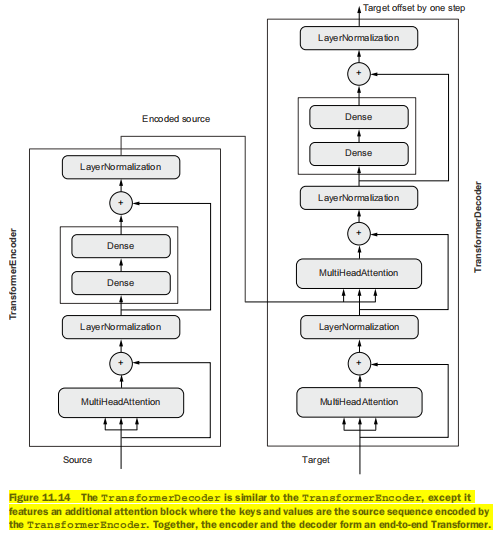  

(Deep Learning in Python, p.359)

In [29]:
embed_dim = 256
dense_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype='int64', name='english')
x = PositionalEmbedding(sequence_length, vocabulary_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)

decoder_inputs = keras.Input(shape=(None,), dtype='int64', name='french')
x = PositionalEmbedding(sequence_length, vocabulary_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocabulary_size, activation='softmax')(x)

transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

transformer.compile(optimizer='rmsprop',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

callbacks = [
    keras.callbacks.ModelCheckpoint('saved_models/eng_fre_transformer_model.keras',
                                   save_best_only=True)
]

###### Training the Transformer model

In [30]:
transformer.fit(train_ds, epochs=30, callbacks=callbacks, validation_data=val_ds)

Epoch 1/30
1474/1474 [==============================] - 196s 127ms/step - loss: 1.6214 - accuracy: 0.4628 - val_loss: 1.2518 - val_accuracy: 0.5562
Epoch 2/30
1474/1474 [==============================] - 187s 127ms/step - loss: 1.2699 - accuracy: 0.5773 - val_loss: 1.0999 - val_accuracy: 0.6105
Epoch 3/30
1474/1474 [==============================] - 187s 127ms/step - loss: 1.1290 - accuracy: 0.6195 - val_loss: 1.0464 - val_accuracy: 0.6338
Epoch 4/30
1474/1474 [==============================] - 186s 127ms/step - loss: 1.0587 - accuracy: 0.6458 - val_loss: 1.0160 - val_accuracy: 0.6482
Epoch 5/30
1474/1474 [==============================] - 187s 127ms/step - loss: 1.0194 - accuracy: 0.6637 - val_loss: 0.9991 - val_accuracy: 0.6586
Epoch 6/30
1474/1474 [==============================] - 187s 127ms/step - loss: 0.9917 - accuracy: 0.6783 - val_loss: 0.9849 - val_accuracy: 0.6653
Epoch 7/30
1474/1474 [==============================] - 187s 127ms/step - loss: 0.9711 - accuracy: 0.6898 - val_

#### 3.5 Translating new sentences with the Transformer model

In [39]:
fre_vocab = target_vectorization.get_vocabulary()
fre_index_lookup = dict(zip(range(len(fre_vocab)), fre_vocab))
max_decoded_sentence_length = 20

def translate_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = '[start]'
    
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization(
                            [decoded_sentence])[:, :-1]
        predictions = transformer(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = fre_index_lookup[sampled_token_index]
        decoded_sentence += ' ' + sampled_token
        if sampled_token == '[end]':
            break
    return decoded_sentence
    
eng_test_texts = [pair[0] for pair in test_pairs]
for _ in range(20):
    sentence = random.choice(eng_test_texts)
    print('-')
    print(sentence)
    print(translate_sequence(sentence))

-
I don't recognize that name.
[start] je ne [UNK] pas que ce nom [end]
-
When are you going back to your own country?
[start] quand vastu rentrer à ton pays [end]
-
Is it always this cold?
[start] estce souvent du temps [end]
-
She attended the meeting.
[start] elle a la réunion à [UNK] [end]
-
What's your favorite number?
[start] quel est ton numéro de téléphone préférée [end]
-
Tom always does that.
[start] tom fait toujours ça [end]
-
Everyone's a winner.
[start] tout le monde y [UNK] un [UNK] [end]
-
I wear a tie almost every day.
[start] je porte une cravate presque tous les jours [end]
-
Is nicotine as addictive as heroin?
[start] estce [UNK] mieux de [UNK] [end]
-
There is nothing to worry about.
[start] il ny a rien à ce sujet [end]
-
Water is heavier than oil.
[start] leau est plus lourd que [UNK] [end]
-
He was too drunk to drive home.
[start] il était trop tombé à [UNK] pour rentrer à la maison [end]
-
She always buys expensive clothes.
[start] elle compte toujours que de v